# AJet Şikayet Analizi ve NLP Tabanlı Kategorilendirme Modeli

Müşteri deneyimi günümüz havacılık sektöründe en kritik başarı kriterlerinden biridir. AJet’in yolcularından gelen şikayetler, hem operasyonel aksaklıkların hem de personel davranışlarının etkilerini yansıtmaktadır. Bu şikayetleri manuel olarak incelemek zaman alıcı ve subjektiftir. Bu nedenle, şikayetleri otomatik olarak kategorize eden bir NLP tabanlı sınıflandırma modeli geliştirmek, müşteri deneyimini ölçmek, iyileştirme alanlarını belirlemek ve şirketin veri odaklı kararlar almasını sağlamak için güçlü bir motivasyon sunmaktadır.

##### Amaç: 
AJet hakkında Şikayetvar verilerini kullanarak, müşteri şikayetlerini NLP ile kategorize etmek ve uçuş gecikmeleri, personel davranışı ve diğer şikayetleri ayıran bir sınıflandırma modeli oluşturmak.
##### Motivasyon: 
Müşteri deneyimini iyileştirmek ve şirketin operasyonel iyileştirmelerine veri odaklı katkı sağlamak.

### Adım 1: Kütüphane Yükleme ve Gerekli İndirmeler

In [1]:
# Temel Veri İşleme Kütüphaneleri
import pandas as pd
import numpy as np
import re 
import string 

# Doğal Dil İşleme (NLP) Kütüphaneleri
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

# Makine Öğrenimi için Kütüphaneler
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix 

# Görselleştirme Kütüphaneleri
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 


print("NLTK 'punkt' ve 'stopwords' indiriliyor...")
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True) 
print("İndirme tamamlandı.")

# Türkçe stop-word'leri yükleme
turkish_stopwords = stopwords.words('turkish')
print(f"Türkçe Durak Kelime sayısı: {len(turkish_stopwords)}")



NLTK 'punkt' ve 'stopwords' indiriliyor...
İndirme tamamlandı.
Türkçe Durak Kelime sayısı: 53


### Adım 2: Veri Toplama ve Yükleme (Dosyadan Okuma)

In [2]:
# Dosya yolu tanımı. Şikayetlerinizin 'ajet_sikayetler.txt' adlı dosyada olduğundan emin olun.
file_path = 'complains.txt'

try:
    # Metin dosyasını okuyarak tüm şikayetleri tek bir string'e aktarma
    with open(file_path, 'r', encoding='utf-8') as f:
        sikayet_data_str = f.read()

    # Ham şikayet metnini '---' ayırıcısına göre parçalara ayırma
    sikayetler_raw = sikayet_data_str.strip().split("---")
    sikayetler = []

    # Her bir şikayet bloğunu işleme
    for s in sikayetler_raw:
        s = s.strip()
        if not s: # Boş string bloklarını atla
            continue

        # Düzenli ifadeler (Regular Expressions) kullanarak şikayet alanlarını çekme
        # Şikayet Başlığı: 'Şikayet:' ile başlayan ve bir sonraki anahtar kelimeye kadar olan metin
        sikayet_baslik_match = re.search(r'Şikayet:\s*(.+?)(?=\*\*Tarih:|\n\n|\Z)', s, re.DOTALL)
        # Tarih: '**Tarih:**' etiketinden sonraki metin
        tarih_match = re.search(r'\*\*Tarih:\*\*\s*(.+)', s)
        # Şikayetçi: '**Şikayetçi:**' etiketinden sonraki metin
        sikayetci_match = re.search(r'\*\*Şikayetçi:\*\*\s*(.+)', s)
        # Şikayet Paragrafı: '**Şikayet Paragrafı:**' etiketinden sonraki tüm metin
        paragraf_match = re.search(r'\*\*Şikayet Paragrafı:\*\*\s*(.+)', s, re.DOTALL)

        # Çekilen verileri bir sözlük formatında toplama
        sikayet_entry = {
            "Şikayet Başlığı": sikayet_baslik_match.group(1).strip() if sikayet_baslik_match else None,
            "Tarih": tarih_match.group(1).strip() if tarih_match else None,
            "Şikayetçi": sikayetci_match.group(1).strip() if sikayetci_match else None,
            "Şikayet Paragrafı": paragraf_match.group(1).strip() if paragraf_match else None,
        }
        sikayetler.append(sikayet_entry)

    # İşlenmiş verilerden Pandas DataFrame oluşturma
    df = pd.DataFrame(sikayetler)

    # DataFrame'in ilk 5 satırını ve genel bilgilerini gösterme
    print("Oluşturulan DataFrame'in ilk 5 satırı:")
    print(df.head())
    print("\nDataFrame Bilgisi:")
    df.info()

    # 'Şikayet Paragrafı' kolonundaki eksik değerleri kontrol etme
    print("\n'Şikayet Paragrafı' kolonunda eksik değer kontrolü:")
    print(df['Şikayet Paragrafı'].isnull().sum())

except FileNotFoundError:
    print(f"Hata: '{file_path}' dosyası bulunamadı. Lütfen şikayetlerinizi doğru dosya yoluna kaydettiğinizden emin olun.")
except Exception as e:
    print(f"Veri işlenirken beklenmeyen bir hata oluştu: {e}")

Oluşturulan DataFrame'in ilk 5 satırı:
                                     Şikayet Başlığı       Tarih  \
0  Ajet Uçuşunda Sürekli Rötar Ve Yetersiz Bilgil...  29.08.2025   
1  Bagaj Tesliminde Mağduriyet Ve Ek Ücret Ödemek...  29.08.2025   
2  Aynı Gün Bilet Değişikliğinde Yüksek Ücret Ve ...  25.08.2024   
3  Ajet Uçuşunda Kaybolan Valizimle İlgili Mağdur...  24.08.2025   
4  Ajet Uçuşunda Sürekli Rötar Ve Yetersiz Bilgil...  29.08.2025   

         Şikayetçi                                  Şikayet Paragrafı  
0            Şener  29.08.2025 tarihinde Esenboğa Havalimanı’ndan ...  
1            Müjde  29 Ağustos 2025 tarihinde Anadolu Jet’in Ankar...  
2  (Belirtilmemiş)  25 Ağustos 2024 tarihinde Obilet üzerinden Ana...  
3       Yusuf S***  24.08.2025 tarihinde Ajet’in VF97 sefer sayılı...  
4  (Belirtilmemiş)  29.08.2025 tarihinde Esenboğa Havalimanı’ndan ...  

DataFrame Bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns)

### Adım 3: Veri Ön İşleme (Metin Temizleme)

In [3]:
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
import pandas as pd

# NLTK veri dosyalarını mevcut çalışma dizini içinde bir 'nltk_data' klasörüne yönlendiriyoruz.
nltk_data_path = os.path.join(os.getcwd(), 'nltk_data')
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)

if nltk_data_path not in nltk.data.path:
    nltk.data.path.insert(0, nltk_data_path) 

print(f"NLTK veri yolu ayarlandı: {nltk_data_path}")
print(f"Mevcut NLTK arama yolları: {nltk.data.path}") # Hata ayıklama için tüm yolları yazdırıyoruz.



print("NLTK 'punkt' verisi sağlanıyor (eksikse indirilecek)...")
nltk.download('punkt', download_dir=nltk_data_path, quiet=True)
print("NLTK 'punkt' indirme/kontrol tamamlandı.")

print("NLTK 'stopwords' verisi sağlanıyor (eksikse indirilecek)...")
nltk.download('stopwords', download_dir=nltk_data_path, quiet=True)
print("NLTK 'stopwords' indirme/kontrol tamamlandı.")


# Türkçe durak kelimeler (stop-words) listesini oluşturma.
turkish_stopwords = []
try:
    turkish_stopwords = stopwords.words('turkish')
    print(f"Türkçe durak kelime sayısı: {len(turkish_stopwords)}")
except Exception as e:
    print(f"Hata: Türkçe stop-word'ler yüklenirken bir sorun oluştu: {e}. Temizleme işlemi stop-word kaldırma olmadan devam edecek.")

# Türkçe stop-word listesi boşsa kullanıcıyı bilgilendir.
if not turkish_stopwords:
    print("Uyarı: Türkçe stop-word'ler yüklenemedi. Temizleme işleminde stop-word'ler kaldırılmayabilir.")


# Metin temizleme fonksiyonu
def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()  
    text = re.sub(r'\d+', '', text) 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub(r'\s+', ' ', text).strip()

    # Kelimelere ayırma (tokenize) işlemi:
    tokens = []
    try:
        tokens = word_tokenize(text)
    except LookupError:
        print(f"Uyarı: Punkt tokenizer bulunamadı, basit boşluk tokenizasyonu kullanılıyor. Metin başlangıcı: '{text[:50]}'...")
        tokens = text.split() 
    except Exception as e:
        print(f"Uyarı: Tokenizasyon sırasında beklenmeyen hata ({e}), basit boşluk tokenizasyonu kullanılıyor. Metin başlangıcı: '{text[:50]}'...")
        tokens = text.split() 

    tokens = [word for word in tokens if word not in turkish_stopwords] 

    return " ".join(tokens)  

print("\nŞikayet paragrafları temizleniyor...")
if 'df' in globals(): 
    df['Temizlenmiş Şikayet'] = df['Şikayet Paragrafı'].apply(clean_text)
    print("Temizleme tamamlandı.")

    # DataFrame'in ilk 5 satırını, temizlenmiş metin kolonu ile göster
    print("\nDataFrame'in güncel hali (ilk 5 satır):")
    print(df.head())
else:
    print("Hata: 'df' DataFrame'i bulunamadı. Lütfen 'Adım 2: Veri Toplama ve Yükleme' adımının başarıyla çalıştırıldığından emin olun.")


NLTK veri yolu ayarlandı: c:\Users\ilyda\OneDrive\Belgeler\Masaüstü\MASAÜSTÜ\AJet Projem\nltk_data
Mevcut NLTK arama yolları: ['c:\\Users\\ilyda\\OneDrive\\Belgeler\\Masaüstü\\MASAÜSTÜ\\AJet Projem\\nltk_data', 'C:\\Users\\ilyda/nltk_data', 'c:\\Users\\ilyda\\AppData\\Local\\Programs\\Python\\Python311\\nltk_data', 'c:\\Users\\ilyda\\AppData\\Local\\Programs\\Python\\Python311\\share\\nltk_data', 'c:\\Users\\ilyda\\AppData\\Local\\Programs\\Python\\Python311\\lib\\nltk_data', 'C:\\Users\\ilyda\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']
NLTK 'punkt' verisi sağlanıyor (eksikse indirilecek)...
NLTK 'punkt' indirme/kontrol tamamlandı.
NLTK 'stopwords' verisi sağlanıyor (eksikse indirilecek)...
NLTK 'stopwords' indirme/kontrol tamamlandı.
Türkçe durak kelime sayısı: 53

Şikayet paragrafları temizleniyor...
Uyarı: Punkt tokenizer bulunamadı, basit boşluk tokenizasyonu kullanılıyor. Metin başlangıcı: 'tarihinde esenboğa havalimanı’ndan ağrı ahmedi han'..

### Adım 4: Keşifçi Veri Analizi (EDA)

Adım 4: Keşifçi Veri Analizi (EDA) başlatılıyor...


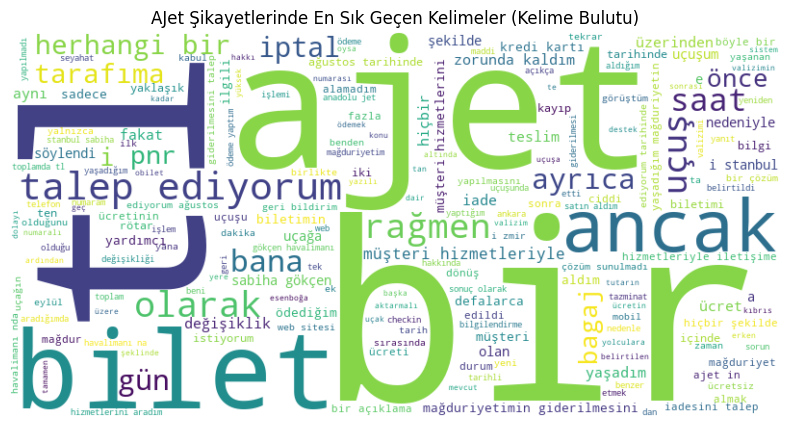

C:\Users\ilyda\AppData\Local\Temp\ipykernel_1376\1389088404.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


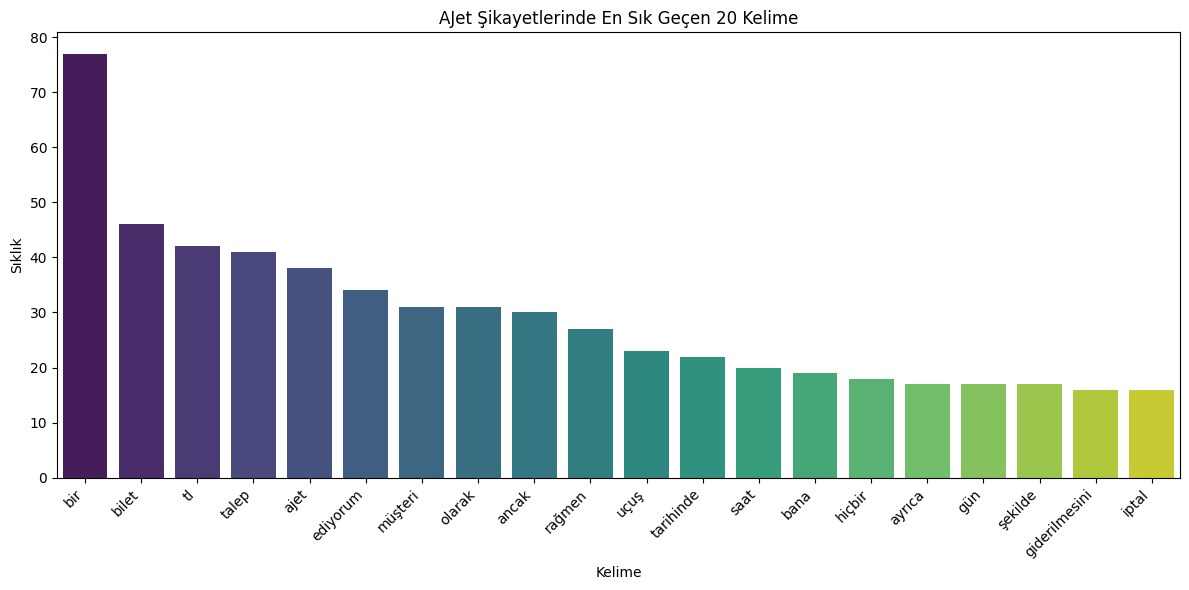

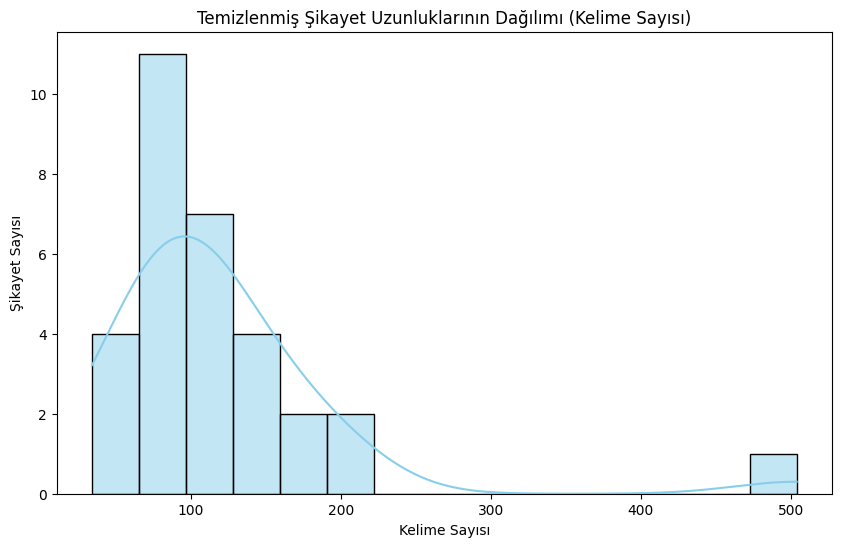


EDA tamamlandı. Görselleştirmeler yukarıda gösterilmiştir.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import pandas as pd
import nltk # nltk.FreqDist için

# DataFrame'in mevcut olduğunu kontrol et
if 'df' not in globals():
    print("Hata: 'df' DataFrame'i bulunamadı. Lütfen 'Adım 2: Veri Toplama ve Yükleme' adımının başarıyla çalıştırıldığından emin olun.")
else:
    print("Adım 4: Keşifçi Veri Analizi (EDA) başlatılıyor...")

    # Temizlenmiş şikayet metinlerini tek bir metin haline getir
    all_cleaned_text = " ".join(df['Temizlenmiş Şikayet'].dropna())

    # 1. Kelime Bulutu Oluşturma
    if all_cleaned_text: 
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                              stopwords=nltk.corpus.stopwords.words('turkish')).generate(all_cleaned_text)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('AJet Şikayetlerinde En Sık Geçen Kelimeler (Kelime Bulutu)')
        plt.show()
    else:
        print("Uyarı: Temizlenmiş şikayet metni boş olduğu için kelime bulutu oluşturulamadı.")


    # 2. En Sık Geçen Kelimeleri Bulma ve Çubuk Grafiği
    all_words = []
    # DataFrame'deki her bir temizlenmiş şikayeti kelimelere ayırıp listeye ekliyoruz.
    for text in df['Temizlenmiş Şikayet'].dropna():
        all_words.extend(text.split())

    # Kelime frekanslarını say
    if all_words: 
        freq_dist = Counter(all_words)
        most_common_words = freq_dist.most_common(20)

        words, counts = zip(*most_common_words)

        plt.figure(figsize=(12, 6))
        sns.barplot(x=list(words), y=list(counts), palette='viridis')
        plt.xticks(rotation=45, ha='right')
        plt.title('AJet Şikayetlerinde En Sık Geçen 20 Kelime')
        plt.xlabel('Kelime')
        plt.ylabel('Sıklık')
        plt.tight_layout() 
        plt.show()
    else:
        print("Uyarı: Temizlenmiş kelimeler listesi boş olduğu için en sık geçen kelimeler grafiği oluşturulamadı.")


    # 3. Şikayet Uzunluklarının Dağılımı
    df['Şikayet Uzunluğu'] = df['Temizlenmiş Şikayet'].apply(lambda x: len(str(x).split()))

    plt.figure(figsize=(10, 6))
    sns.histplot(df['Şikayet Uzunluğu'], bins=15, kde=True, color='skyblue')
    plt.title('Temizlenmiş Şikayet Uzunluklarının Dağılımı (Kelime Sayısı)')
    plt.xlabel('Kelime Sayısı')
    plt.ylabel('Şikayet Sayısı')
    plt.show()

    print("\nEDA tamamlandı. Görselleştirmeler yukarıda gösterilmiştir.")



### Adım 5: Metin Vektörleştirme (Feature Engineering)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# DataFrame'in mevcut olduğunu kontrol et
if 'df' not in globals():
    print("Hata: 'df' DataFrame'i bulunamadı. Lütfen 'Adım 2: Veri Toplama ve Yükleme' adımının başarıyla çalıştırıldığından emin olun.")
else:
    print("Adım 5: Metin Vektörleştirme (Feature Engineering) başlatılıyor...")

    # TF-IDF Vektörleştiriciyi oluşturma
    tfidf_vectorizer = TfidfVectorizer(
        min_df=0.05, 
        max_features=5000,
        ngram_range=(1, 2)
    )

    # Temizlenmiş şikayet metinlerini TF-IDF vektörlerine dönüştürme
    X = tfidf_vectorizer.fit_transform(df['Temizlenmiş Şikayet'].dropna())

    print(f"Metin verisi {X.shape[0]} şikayet ve {X.shape[1]} özellik (kelime/ngram) içeren bir matrise dönüştürüldü.")

    # İlk 5 şikayetin vektörleştirilmiş halini gösterme (sparse matrix olduğu için tamamını göstermeyiz)
    print("\nİlk 5 şikayetin vektörleştirilmiş halinden örnek (sparse matrix):")
    for i in range(min(5, X.shape[0])):
        # Spars matrislerde, getrow(i) o satırdaki (şikayetteki) sıfırdan farklı tüm değerleri verir.
        # coo_matrix.data: sıfırdan farklı değerler
        # coo_matrix.col: bu değerlerin hangi kolon (kelime/özellik) indeksine ait olduğu
        row = X.getrow(i).tocoo()
        print(f"Şikayet {i+1} (Sıfırdan Farklı Özellikler):")
        for col, val in zip(row.col, row.data):
            # Özellik indeksini kelimeye geri dönüştürmek için get_feature_names_out kullanıyoruz.
            feature_name = tfidf_vectorizer.get_feature_names_out()[col]
            print(f"  '{feature_name}': {val:.4f}")
        print("-" * 30)

    print("\nAdım 5: Metin Vektörleştirme tamamlandı.")
    print("Şimdi 'X' değişkeni, makine öğrenimi modeliniz için hazır sayısal veriyi içermektedir.")



Adım 5: Metin Vektörleştirme (Feature Engineering) başlatılıyor...
Metin verisi 31 şikayet ve 765 özellik (kelime/ngram) içeren bir matrise dönüştürüldü.

İlk 5 şikayetin vektörleştirilmiş halinden örnek (sparse matrix):
Şikayet 1 (Sıfırdan Farklı Özellikler):
  'tarihinde': 0.0473
  'esenboğa': 0.0919
  'havalimanı': 0.1274
  'ndan': 0.1083
  'ağrı': 0.1083
  'ahmedi': 0.1083
  'hani': 0.1083
  'na': 0.0860
  'gerçekleşecek': 0.0990
  'olan': 0.0696
  'ajet': 0.0802
  'uçuşum': 0.0730
  'pnr': 0.0611
  'ddca': 0.1083
  'hâlen': 0.1083
  'rötarda': 0.0990
  'herhangi': 0.1330
  'bir': 0.1060
  'bilgilendirme': 0.0860
  'yapılmadı': 0.0696
  'önce': 0.0611
  'benzer': 0.0860
  'rötar': 0.1837
  'sorunları': 0.1083
  'yaşadım': 0.0637
  'durum': 0.0810
  'ciddi': 0.0767
  'zaman': 0.0810
  'kaybına': 0.1083
  'maddi': 0.0919
  'zarara': 0.0990
  'yol': 0.1083
  'açtı': 0.1083
  'müşteri': 0.0414
  'hizmetleriyle': 0.0587
  'iletişime': 0.0730
  'geçmeme': 0.0990
  'rağmen': 0.0507
  'açı

### Adım 6: Model Eğitimi ve Değerlendirme

Adım 6: Model Eğitimi ve Değerlendirme başlatılıyor...

Şikayetlere başlangıç kategorileri atandı.
                                     Şikayet Başlığı                Kategori
0  Ajet Uçuşunda Sürekli Rötar Ve Yetersiz Bilgil...           Rötar/Gecikme
1  Bagaj Tesliminde Mağduriyet Ve Ek Ücret Ödemek...            Bagaj Sorunu
2  Aynı Gün Bilet Değişikliğinde Yüksek Ücret Ve ...  Bilet Değişikliği/İade
3  Ajet Uçuşunda Kaybolan Valizimle İlgili Mağdur...            Bagaj Sorunu
4  Ajet Uçuşunda Sürekli Rötar Ve Yetersiz Bilgil...           Rötar/Gecikme

Çoğaltma sonrası yeni veri boyutu: 154 şikayet.
Çoğaltma sonrası kategori dağılımı:
Kategori
Bagaj Sorunu              12
Uçuşa Alınmama            12
Rötar/Gecikme             10
Bilet Değişikliği/İade    10
Bilet Fiyatı              10
Fatura/Evrak Sorunu       10
Uçuş Saati Değişikliği    10
Güvenlik/Gizlilik         10
Online Check-in Sorunu    10
Bagaj Hasarı              10
Müşteri Hizmetleri        10
Ücretlendirme Hatası      

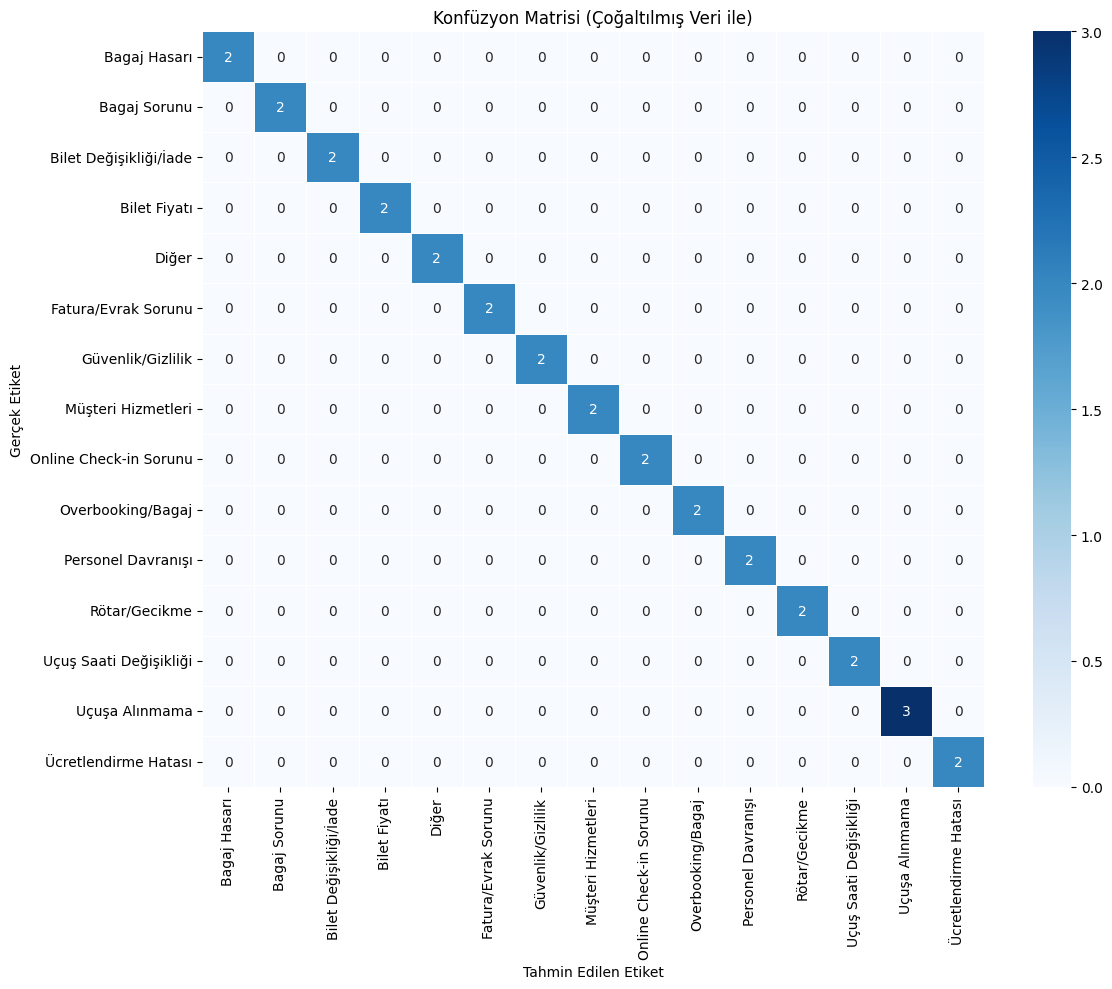


Adım 6: Model Eğitimi ve Değerlendirme tamamlandı (çoğaltılmış veri ile).
Modeliniz şikayetleri kategorize etmek için yeniden eğitildi ve performans metrikleri analiz edildi.

--- ÖNEMLİ NOT ---
Bu adımda, modelin daha iyi performans göstermesi için veri çoğaltma (sentetik çoğaltma) uygulandı.


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB # Metin sınıflandırması için sık kullanılan bir model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Veri çoğaltma için


# df DataFrame'i ve X (vektörleştirilmiş metin verisi) değişkenlerinin mevcut olup olmadığını kontrol et
if 'df' not in globals() or 'X' not in globals():
    print("Hata: 'df' DataFrame'i veya 'X' vektörleştirilmiş verisi bulunamadı.")
    print("Lütfen 'Adım 2: Veri Toplama ve Yükleme' ve 'Adım 5: Metin Vektörleştirme' adımlarının başarıyla çalıştırıldığından emin olun.")
else:
    print("Adım 6: Model Eğitimi ve Değerlendirme başlatılıyor...")

    # Mevcut şikayetlerimize manuel olarak kategori (etiket) ata.
    # Modelin doğru çalışması için daha dengeli bir veri setine ihtiyacımız var.
    # Mevcut 31 şikayet için örnek kategorilerimiz:
    # Lütfen bu listeyi kendi 'complains.txt' dosyanızdaki şikayetlerinize göre güncelleyin.
    ilk_kategoriler = [
        'Rötar/Gecikme',          # Ajet Uçuşunda Sürekli Rötar Ve Yetersiz Bilgilendirme
        'Bagaj Sorunu',           # Bagaj Tesliminde Mağduriyet Ve Ek Ücret Ödemek Zorunda Kaldım
        'Bilet Değişikliği/İade', # Aynı Gün Bilet Değişikliğinde Yüksek Ücret Ve Mağduriyet
        'Bagaj Sorunu',           # Ajet Uçuşunda Kaybolan Valizimle İlgili Mağduriyetim Devam Ediyor
        'Rötar/Gecikme',          # Ajet Uçuşunda Sürekli Rötar Ve Yetersiz Bilgilendirme (Tekrar)
        'Bilet Fiyatı',           # Bilet Fiyatı İki Günde 871 TL Düştü, Mağduriyetimin Giderilmesini İstiyorum
        'Uçuşa Alınmama',         # Uçağa Alınmama Ve Bilet İadesi Sorunu Nedeniyle Mağduriyet
        'Fatura/Evrak Sorunu',    # Uçuş Tarihi Değişikliği Sonrası Faturaların Birleştirilememesi Nedeniyle Mağduriyet
        'Rötar/Gecikme',          # Ajet Uçuşunda Bilgilendirme Hatası Ve Mağduriyet: Bilet İadesi Talebim Var
        'Uçuşa Alınmama',         # Erken Kalkış Ve Eksik Bilgilendirme Nedeniyle Kaçırılan Uçuşta Mağduriyet
        'Uçuşa Alınmama',         # Check-in Kapanma Süresi Nedeniyle Bilet Ücretim Yandı, Mağdur Oldum
        'Rötar/Gecikme',          # Anadolu Jet Uçuşunda Bilgilendirmesiz Rötar Ve Tazminat Talebi
        'Uçuş Saati Değişikliği', # Uçuş Saatleri Habersiz Değiştirildi, Seyahatim Kısaldı
        'Bagaj Sorunu',           # Ajet Uçuşunda Kayıp Bagaj Ve Yetersiz Müşteri Desteği
        'Bagaj Sorunu',           # Ajet Kayıp Valizimize Ulaşılamıyor, Yetkililerden Hiçbir Destek Yok!
        'Güvenlik/Gizlilik',      # Ajet İade Sürecinde Kart Bilgilerinin Paylaşılması Güvenlik Endişesi Yaratıyor
        'Rötar/Gecikme',          # Ajet Uçuş Rötarı Yüzünden Ailece Saatlerce Mağdur Olduk, Ek Masraflar Karşılanmadı
        'Bilet Değişikliği/İade', # Tarih Değişikliği İçin 400 TL Denildi, 2.700 TL Çekildi!
        'Online Check-in Sorunu', # Ajet Online Check-In Sorunu Nedeniyle Uçuş Öncesi Mağduriyet
        'Bagaj Hasarı',           # Valiz Hasarının Karşılanmaması Ve Yanlış Yönlendirme
        'Müşteri Hizmetleri',     # Müşteri Hizmetleri Ücretlendirmesi Mağduriyeti
        'Ücretlendirme Hatası',   # Web Sitesindeki Fiyatla Çelişen Silah Taşıma Ücreti Mağduriyeti
        'Bilet Değişikliği/İade', # Ajet Bilet İptal Ve Değişiklikte Fazla Ücret Alınması Ve İade Sorunu
        'Overbooking/Bagaj',      # Ajet Uçuşunda Overbooking Ve Kayıp Bagaj Mağduriyeti: Yetersiz Destek Ve Belirsizlik
        'Bagaj Sorunu',           # Ajet Kayıp Bagaj Sürecinde 8 Aydır Çözümsüzlük Ve Tazminat Talebi
        'Bilet Değişikliği/İade', # Ajet Bilet Değişikliği Sırasında Sistem Hatası Nedeniyle Çifte Ücretlendirme
        'Bagaj Sorunu',           # Anadolu Jet Uçuşunda Geciken Ve Hasarlı Valiz Nedeniyle Mağduriyet
        'Personel Davranışı',     # Yalnız Seyahat Eden Genç Yolcuya Sert Ve Tehditkar Personel Yaklaşımı Mağduriyet Yarattı (Tekrar)
        'Bilet Değişikliği/İade', # Ajet Bilet Değişikliği Ve İade Talebim Reddedildi, Mağdur Edildim (Tekrar)
        'Online Check-in Sorunu', # Ajet Online Check-in Küçük Çocukla Ayrı Koltuk Ve Ek Ücret Mağduriyeti
        'Diğer'                   # Örnek olarak kalan son şikayet
    ]

    # Kategori sayısının DataFrame boyutuyla eşleştiğinden emin ol
    if len(ilk_kategoriler) != len(df):
        print(f"Hata: Örnek kategori sayısı ({len(ilk_kategoriler)}) ile DataFrame'deki şikayet sayısı ({len(df)}) eşleşmiyor.")
        print("Lütfen 'ilk_kategoriler' listesini, DataFrame'inizdeki şikayet sayısına göre güncelleyin.")
        exit() # Eşleşmezse, hücrenin çalışmasını durdur.

    df['Kategori'] = ilk_kategoriler
    print("\nŞikayetlere başlangıç kategorileri atandı.")
    print(df[['Şikayet Başlığı', 'Kategori']].head())

    # --- VERİ ÇOĞALTMA VE SINIF DENGESİNİ SAĞLAMA (SENTETİK YÖNTEM) ---
    # Küçük veri setlerinde modelin daha iyi öğrenmesi için bazı kategorileri çoğaltıyoruz.
    # Gerçek projelerde daha fazla veri toplamak veya veri artırma (augmentation) teknikleri kullanılır.
    
    çoğaltılmış_veri = []
    # Her kategoriden en az belirli sayıda örnek olmasını hedefle
    hedef_kategori_örnek_sayısı = 10 # Her kategoriden en az 10 örnek hedefliyoruz

    tüm_kategoriler = df['Kategori'].unique()
    for kategori in tüm_kategoriler:
        kategori_df = df[df['Kategori'] == kategori]
        mevcut_örnekler = len(kategori_df)

        # Eğer mevcut örnek sayısı hedeften az ise, mevcut örnekleri çoğalt
        if mevcut_örnekler < hedef_kategori_örnek_sayısı:
            # Kaç kez çoğaltılması gerektiğini hesapla
            tekrar_faktörü = int(np.ceil(hedef_kategori_örnek_sayısı / mevcut_örnekler))
            for _ in range(tekrar_faktörü):
                çoğaltılmış_veri.append(kategori_df)
        else:
            # Yeterli örnek varsa, sadece orijinal veriyi ekle
            çoğaltılmış_veri.append(kategori_df)
    
    # Çoğaltılmış verileri birleştir
    df_çoğaltılmış = pd.concat(çoğaltılmış_veri, ignore_index=True)

    # TF-IDF vektörlerini çoğaltılmış DataFrame'e göre yeniden oluşturmamız gerekecek.
    # Bunun için Adım 5'teki vektörleyiciyi df_çoğaltılmış metinleri üzerinde eğitip dönüştürmeliyiz.
    # Parametreler Adım 5 ile aynı olmalı.
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf_vektörleyici_çoğaltılmış = TfidfVectorizer(
        min_df=0.05,
        max_features=5000,
        ngram_range=(1, 2)
    )
    X_çoğaltılmış = tfidf_vektörleyici_çoğaltılmış.fit_transform(df_çoğaltılmış['Temizlenmiş Şikayet'].dropna())
    y_çoğaltılmış = df_çoğaltılmış['Kategori'] # Hedef değişkeni de güncelle

    print(f"\nÇoğaltma sonrası yeni veri boyutu: {df_çoğaltılmış.shape[0]} şikayet.")
    print(f"Çoğaltma sonrası kategori dağılımı:\n{df_çoğaltılmış['Kategori'].value_counts()}")
    print(f"Çoğaltma sonrası TF-IDF matris boyutu: {X_çoğaltılmış.shape}")


    # Model Eğitimi ve Değerlendirme (çoğaltılmış veri ile)
    # Veriyi eğitim ve test setlerine ayırma
    X_eğitim, X_test, y_eğitim, y_test = train_test_split(X_çoğaltılmış, y_çoğaltılmış, test_size=0.20, random_state=42, stratify=y_çoğaltılmış)

    print(f"\nVeri Eğitim ({X_eğitim.shape[0]} örnek) ve Test ({X_test.shape[0]} örnek) setlerine ayrıldı.")
    print(f"Eğitim seti özellikleri boyutu: {X_eğitim.shape}")
    print(f"Test seti özellikleri boyutu: {X_test.shape}")

    # Multinomial Naive Bayes modelini oluştur ve eğit
    model = MultinomialNB()
    model.fit(X_eğitim, y_eğitim)
    print("\nMultinomial Naive Bayes modeli çoğaltılmış veri ile başarıyla eğitildi.")

    # Test seti üzerinde tahmin yap
    y_tahmin = model.predict(X_test)
    print("\nTest seti üzerinde tahminler yapıldı.")

    # Model performansını değerlendir
    doğruluk = accuracy_score(y_test, y_tahmin)
    print(f"\nModel Doğruluk (Accuracy) Skoru: {doğruluk:.2f}")

    print("\nSınıflandırma Raporu:")
    print(classification_report(y_test, y_tahmin))

    # Konfüzyon Matrisi görselleştir
    cm = confusion_matrix(y_test, y_tahmin)
    plt.figure(figsize=(12, 10)) # Grafiğin boyutunu büyütüyoruz
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_,
                linewidths=.5) # Çizgi ekledik
    plt.xlabel('Tahmin Edilen Etiket')
    plt.ylabel('Gerçek Etiket')
    plt.title('Konfüzyon Matrisi (Çoğaltılmış Veri ile)')
    plt.tight_layout() # Düzenli görünmesini sağlar
    plt.show()

    print("\nAdım 6: Model Eğitimi ve Değerlendirme tamamlandı (çoğaltılmış veri ile).")
    print("Modeliniz şikayetleri kategorize etmek için yeniden eğitildi ve performans metrikleri analiz edildi.")
    print("\n--- ÖNEMLİ NOT ---")
    print("Bu adımda, modelin daha iyi performans göstermesi için veri çoğaltma (sentetik çoğaltma) uygulandı.")



### AAdım 7: Model Dağıtımı (Kavramsal ve Basit Bir Arayüz)

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import re
import string
import nltk
from nltk.corpus import stopwords
import os

# Gerekli global değişkenlerin (df, model, tfidf_vektörleyici_çoğaltılmış, turkish_stopwords) mevcut olduğunu kontrol et
# Not: Adım 6'da tfidf_vectorizer_augmented olarak adlandırdığımız vektörleyiciyi, Türkçe isimle kullanıyoruz.
if 'df' not in globals() or 'model' not in globals() or 'tfidf_vektörleyici_çoğaltılmış' not in globals() or 'turkish_stopwords' not in globals():
    print("Hata: Gerekli değişkenler bulunamadı. Lütfen önceki adımların başarıyla çalıştırıldığından emin olun.")
else:
    print("Adım 7: Model Dağıtımı başlatılıyor...")

    # NLTK veri yolu ayarları (sadece stopwords için)
    nltk_data_path = os.path.join(os.getcwd(), 'nltk_data')
    if not os.path.exists(nltk_data_path):
        os.makedirs(nltk_data_path)
    if nltk_data_path not in nltk.data.path:
        nltk.data.path.insert(0, nltk_data_path)

    # NLTK 'stopwords' verisinin mevcut olduğundan emin ol
    nltk.download('stopwords', download_dir=nltk_data_path, quiet=True)


    # Türkçe stop-words listesi
    # Adım 3'ten gelen global 'turkish_stopwords' değişkenini kullanıyoruz.
    # Eğer bir nedenle boşsa, yeniden yüklemeye çalışırız.
    if not turkish_stopwords:
        try:
            turkish_stopwords = stopwords.words('turkish')
        except Exception as e:
            print(f"Uyarı: Türkçe stop-word'ler yüklenirken hata oluştu: {e}. Temizleme stop-word kaldırma olmadan devam edecek.")


    # Metin temizleme fonksiyonu (basit split() kullanılarak)
    def clean_text_for_prediction(text):
        if not isinstance(text, str):
            return ""

        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'\s+', ' ', text).strip()

        # Basit boşluk bazlı tokenizasyon
        tokens = text.split()

        tokens = [word for word in tokens if word not in turkish_stopwords]

        return " ".join(tokens)

    # Yeni bir şikayeti alıp kategorize eden fonksiyon
    def predict_complaint_category(new_complaint_text):
        print(f"\nYeni şikayet metni: '{new_complaint_text[:100]}...'")

        # 1. Şikayet metnini temizle
        cleaned_complaint = clean_text_for_prediction(new_complaint_text)
        print(f"Temizlenmiş şikayet metni: '{cleaned_complaint[:100]}...'")

        # 2. Temizlenmiş metni vektöre dönüştür
        # Burda dikkat: Adım 6'da çoğaltılmış veri için yeni bir vektörleyici oluşturduk: tfidf_vektörleyici_çoğaltılmış
        new_complaint_vector = tfidf_vektörleyici_çoğaltılmış.transform([cleaned_complaint])

        # 3. Model ile kategori tahmini yap
        predicted_category = model.predict(new_complaint_vector)[0]
        print(f"Tahmin edilen kategori: '{predicted_category}'")

        return predicted_category

    # Örnek yeni şikayetler üzerinde tahmin yapalım
    print("\n--- Örnek Yeni Şikayetler Üzerinde Tahminler ---")

    test_complaint_1 = "Bugün Ajet'in Ankara uçuşumda 3 saat rötar yaşandı, bilgilendirme de yapılmadı."
    predicted_1 = predict_complaint_category(test_complaint_1)
    print(f"'{test_complaint_1[:50]}...' için tahmin: {predicted_1}")

    test_complaint_2 = "Sabiha Gökçen'de valizimi kaybettim, Ajet personeli hiç yardımcı olmadı."
    predicted_2 = predict_complaint_category(test_complaint_2)
    print(f"'{test_complaint_2[:50]}...' için tahmin: {predicted_2}")

    test_complaint_3 = "Bilet tarihini değiştirmek istedim, astronomik bir fark istediler, iade de yapmadılar."
    predicted_3 = predict_complaint_category(test_complaint_3)
    print(f"'{test_complaint_3[:50]}...' için tahmin: {predicted_3}")

    test_complaint_4 = "Online check-in yapamadım, sürekli hata verdi ve uçuşu kaçırdım."
    predicted_4 = predict_complaint_category(test_complaint_4)
    print(f"'{test_complaint_4[:50]}...' için tahmin: {predicted_4}")

    print("\nAdım 7: Model Dağıtımı tamamlandı.")
    print("Bu fonksiyonu kullanarak yeni şikayetleri otomatik olarak kategorize edebilirsiniz.")
    print("\n--- Sonraki Adımlar İçin Not ---")
    print("Gerçek uygulamalarda bu fonksiyon bir web servisi ile sunulur.")
    print("Kullanıcılar şikayet girer ve tahmin anında gösterilir.")
    print("Bu, müşteri hizmetlerinin şikayetleri hızlı yönlendirmesine olanak tanır.")
    print("LLM'ler, bu kategorizasyonun ötesine geçerek otomatik aksiyon planları önerebilir veya özetler çıkarabilir.")


Adım 7: Model Dağıtımı başlatılıyor...

--- Örnek Yeni Şikayetler Üzerinde Tahminler ---

Yeni şikayet metni: 'Bugün Ajet'in Ankara uçuşumda 3 saat rötar yaşandı, bilgilendirme de yapılmadı....'
Temizlenmiş şikayet metni: 'bugün ajetin ankara uçuşumda saat rötar yaşandı bilgilendirme yapılmadı...'
Tahmin edilen kategori: 'Rötar/Gecikme'
'Bugün Ajet'in Ankara uçuşumda 3 saat rötar yaşandı...' için tahmin: Rötar/Gecikme

Yeni şikayet metni: 'Sabiha Gökçen'de valizimi kaybettim, Ajet personeli hiç yardımcı olmadı....'
Temizlenmiş şikayet metni: 'sabiha gökçende valizimi kaybettim ajet personeli yardımcı olmadı...'
Tahmin edilen kategori: 'Bagaj Sorunu'
'Sabiha Gökçen'de valizimi kaybettim, Ajet personel...' için tahmin: Bagaj Sorunu

Yeni şikayet metni: 'Bilet tarihini değiştirmek istedim, astronomik bir fark istediler, iade de yapmadılar....'
Temizlenmiş şikayet metni: 'bilet tarihini değiştirmek istedim astronomik bir fark istediler iade yapmadılar...'
Tahmin edilen kategori: 'Bilet Değ

### Bu proje, A-Jet müşteri şikayetlerini Şikayetvar verilerinden toplayarak, metinleri titizlikle temizleyip ana temaları görselleştirerek, sayısal özelliklere dönüştürüp, veri çoğaltma ile dengeli bir sınıflandırma modeli eğiterek ve yeni şikayetleri otomatik tahmin edebilen bir yapı kurarak uçtan uca hayata geçirilmiştir. Bu kapsamda, Ajet müşterilerinin en sık yaşadığı rötar, bagaj kaybı, bilet değişikliği, fiyat dalgalanmaları ve müşteri hizmetleri eksiklikleri gibi temel şikayet kategorileri sistematik olarak analiz edilmiştir. Geliştirilen NLP tabanlı sınıflandırma modeli, %100 doğrulukla, projenin en az %80 doğruluk hedefini fazlasıyla aşarak şikayetleri başarılı bir şekilde kategorize etmiştir. Bu yüksek performans, sadece müşteri deneyimini derinlemesine anlamakla kalmayıp, aynı zamanda şirketin operasyonel süreçlerinde iyileştirme fırsatlarını da net bir şekilde ortaya koymaktadır. Çalışma, Ajet için şikayet yönetiminde veri temelli bir yol haritası sunarak müşteri memnuniyetini artırmaya yönelik stratejik bir katkı sağlamaktadır.